In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [2]:
import numpy as np
import torch
import VIT16
import tqdm
import random
device = torch.device('cuda')

In [3]:
def cvt_data_loader(x,y=None,batch_size= 32,shuffle = True):
    if y is None:
        return torch.utils.data.DataLoader(torch.tensor(x,dtype = torch.float32),batch_size= batch_size,shuffle=shuffle)
    
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(x,dtype = torch.float32),
                              torch.tensor(y,dtype = torch.float32))
                              ,batch_size= batch_size,shuffle=shuffle)
def cvt_one_hot(y,num_classes):
    one_hot = np.zeros((len(y),num_classes))
    one_hot[np.arange(len(y)),y] = 1
    return one_hot

In [4]:
train_dl_lis = []
batch_szie = 200
for i in range(20):
    data = np.load(f'cifar-10-augmented{i}.npz')
    x_train, y_train,  = np.array(data['x_train_aug'],dtype = np.float32)/ 255, data['y_train_aug']
    x_train = x_train.transpose(0,3,1,2)
    y_train = cvt_one_hot(y_train,10)
    train_dl = cvt_data_loader(x_train, y_train, batch_szie, True)
    train_dl_lis.append(train_dl)
x_test, y_test =  np.array(data['x_test'],dtype = np.float32)/255, data['y_test']
x_test = x_test.transpose(0,3,1,2)
y_test = cvt_one_hot(y_test,10)
test_dl = cvt_data_loader(x_test, y_test, batch_szie, True)

In [5]:
model = VIT16.VIT(embedDim=240,num_classes=10,numHeads=12,numLayers=12)

In [6]:
epochs = 150
critarion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4, weight_decay= 5e-4)
seheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs,eta_min= 5e-7)

In [7]:
model = model.to(device)
model = model.train()
train_loss = []
test_loss = []
train_accu = []
test_accu = []
max_accu = 0
min_loss = 1000
tf = True
for epoch in range(1, epochs + 1):
    print(f"Epoch : {epoch}")
    sum_loss = 0
    sum_accu = 0
    model = model.train()
    ind = random.randint(0,len(train_dl_lis) - 1)
    print(f"Using Training Data {ind}")
    train_dl=train_dl_lis[ind]
    for x, y in tqdm.tqdm(train_dl):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        out = model.forward(x)
        loss = critarion(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(),torch.tensor(1))
        optimizer.step()
        sum_loss += float(loss) * len(x)
        sum_accu += float(torch.sum(torch.argmax(out,dim = 1)==torch.argmax(y,dim=1)))
    optimizer.zero_grad()
    seheduler.step()
    torch.cuda.empty_cache()
    sum_loss = sum_loss/ len(train_dl.dataset)
    sum_accu = sum_accu / len(train_dl.dataset)
    print(f"Train Accuracy : {sum_accu}")
    print(f"Train Loss : {sum_loss}")
    train_loss.append(sum_loss)
    train_accu.append(sum_accu)
    sum_loss = 0
    sum_accu = 0
    model = model.eval()
    for x, y in tqdm.tqdm(test_dl):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        out = model.forward(x)
        loss = critarion(out, y)
        sum_loss += float(loss) * len(x)
        sum_accu += float(torch.sum(torch.argmax(out,dim = 1)==torch.argmax(y,dim=1)))
    torch.cuda.empty_cache()
    sum_loss = sum_loss/ len(test_dl.dataset)
    sum_accu = sum_accu / len(test_dl.dataset)
    if sum_accu > max_accu:
        max_accu = sum_accu
        torch.save({'state_dict' : model.state_dict(), 'cfgDict' : model.cfgDict},"VIT16_accu")
    if sum_loss < min_loss:
        min_loss = sum_loss
        torch.save({'state_dict' : model.state_dict(), 'cfgDict' : model.cfgDict},"VIT16_loss")
    print(f"Val Accuracy : {sum_accu}")
    print(f"Val Loss : {sum_loss}")
    test_accu.append(sum_accu)
    test_loss.append(sum_loss)
    # if ((epoch > 2) and (((test_loss[-1] > (test_loss[-2])) and tf) 
    #                      or (train_loss[-1] < (test_loss[-1] - 0.15)) 
    #                      or ((train_accu[-1] > (test_accu[-1] + 0.025)) and tf))):
    #     print("Intersting Saved at epoch: {}".format(epoch))
    #     torch.save({'state_dict' : model.state_dict(), 'cfgDict' : model.cfgDict},f"Pre_VIT{epoch}")
    #     tf = False

Epoch : 1
Using Training Data 14


100%|██████████| 250/250 [00:30<00:00,  8.27it/s]


Train Accuracy : 0.19346
Train Loss : 2.0642877535820006


100%|██████████| 50/50 [00:02<00:00, 24.67it/s]


Val Accuracy : 0.1735
Val Loss : 2.257745394706726
Epoch : 2
Using Training Data 12


100%|██████████| 250/250 [00:29<00:00,  8.38it/s]


Train Accuracy : 0.28492
Train Loss : 1.8316501693725586


100%|██████████| 50/50 [00:02<00:00, 24.29it/s]


Val Accuracy : 0.2962
Val Loss : 1.9195272517204285
Epoch : 3
Using Training Data 19


100%|██████████| 250/250 [00:30<00:00,  8.30it/s]


Train Accuracy : 0.37212
Train Loss : 1.6619251284599303


100%|██████████| 50/50 [00:01<00:00, 25.14it/s]


Val Accuracy : 0.4025
Val Loss : 1.635789659023285
Epoch : 4
Using Training Data 2


100%|██████████| 250/250 [00:29<00:00,  8.56it/s]


Train Accuracy : 0.42394
Train Loss : 1.5415971755981446


100%|██████████| 50/50 [00:01<00:00, 25.09it/s]


Val Accuracy : 0.4776
Val Loss : 1.4561629343032836
Epoch : 5
Using Training Data 18


100%|██████████| 250/250 [00:30<00:00,  8.32it/s]


Train Accuracy : 0.46556
Train Loss : 1.4485254426002503


100%|██████████| 50/50 [00:02<00:00, 24.98it/s]


Val Accuracy : 0.4979
Val Loss : 1.405315637588501
Epoch : 6
Using Training Data 15


100%|██████████| 250/250 [00:29<00:00,  8.52it/s]


Train Accuracy : 0.49688
Train Loss : 1.3777164525985717


100%|██████████| 50/50 [00:01<00:00, 25.77it/s]


Val Accuracy : 0.5551
Val Loss : 1.220545997619629
Epoch : 7
Using Training Data 0


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.52422
Train Loss : 1.3108848686218262


100%|██████████| 50/50 [00:02<00:00, 24.70it/s]


Val Accuracy : 0.5891
Val Loss : 1.1507438218593598
Epoch : 8
Using Training Data 5


100%|██████████| 250/250 [00:29<00:00,  8.41it/s]


Train Accuracy : 0.55486
Train Loss : 1.2389508290290832


100%|██████████| 50/50 [00:02<00:00, 24.52it/s]


Val Accuracy : 0.5951
Val Loss : 1.1201465320587158
Epoch : 9
Using Training Data 0


100%|██████████| 250/250 [00:29<00:00,  8.51it/s]


Train Accuracy : 0.58574
Train Loss : 1.1568955454826355


100%|██████████| 50/50 [00:01<00:00, 25.36it/s]


Val Accuracy : 0.6255
Val Loss : 1.0530844414234162
Epoch : 10
Using Training Data 17


100%|██████████| 250/250 [00:29<00:00,  8.56it/s]


Train Accuracy : 0.59494
Train Loss : 1.1344137902259828


100%|██████████| 50/50 [00:01<00:00, 25.73it/s]


Val Accuracy : 0.6296
Val Loss : 1.0417936420440674
Epoch : 11
Using Training Data 7


100%|██████████| 250/250 [00:29<00:00,  8.55it/s]


Train Accuracy : 0.61366
Train Loss : 1.0845186991691589


100%|██████████| 50/50 [00:01<00:00, 25.39it/s]


Val Accuracy : 0.65
Val Loss : 0.9980618774890899
Epoch : 12
Using Training Data 12


100%|██████████| 250/250 [00:29<00:00,  8.54it/s]


Train Accuracy : 0.6275
Train Loss : 1.0453421137332917


100%|██████████| 50/50 [00:01<00:00, 25.29it/s]


Val Accuracy : 0.667
Val Loss : 0.9358666408061981
Epoch : 13
Using Training Data 7


100%|██████████| 250/250 [00:29<00:00,  8.57it/s]


Train Accuracy : 0.65106
Train Loss : 0.9814825749397278


100%|██████████| 50/50 [00:01<00:00, 25.66it/s]


Val Accuracy : 0.6585
Val Loss : 0.968241093158722
Epoch : 14
Using Training Data 6


100%|██████████| 250/250 [00:28<00:00,  8.64it/s]


Train Accuracy : 0.64988
Train Loss : 0.9788903481960297


100%|██████████| 50/50 [00:01<00:00, 26.17it/s]


Val Accuracy : 0.6729
Val Loss : 0.918753731250763
Epoch : 15
Using Training Data 10


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.66126
Train Loss : 0.9524049413204193


100%|██████████| 50/50 [00:01<00:00, 25.60it/s]


Val Accuracy : 0.6957
Val Loss : 0.8776235115528107
Epoch : 16
Using Training Data 0


100%|██████████| 250/250 [00:28<00:00,  8.68it/s]


Train Accuracy : 0.67734
Train Loss : 0.9114242951869964


100%|██████████| 50/50 [00:01<00:00, 26.05it/s]


Val Accuracy : 0.7005
Val Loss : 0.8598847699165344
Epoch : 17
Using Training Data 2


100%|██████████| 250/250 [00:28<00:00,  8.67it/s]


Train Accuracy : 0.67828
Train Loss : 0.8993426892757416


100%|██████████| 50/50 [00:01<00:00, 26.12it/s]


Val Accuracy : 0.709
Val Loss : 0.8398130786418915
Epoch : 18
Using Training Data 4


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.6914
Train Loss : 0.8700615921020508


100%|██████████| 50/50 [00:01<00:00, 26.00it/s]


Val Accuracy : 0.706
Val Loss : 0.8398440873622894
Epoch : 19
Using Training Data 1


100%|██████████| 250/250 [00:28<00:00,  8.65it/s]


Train Accuracy : 0.70226
Train Loss : 0.8427701997756958


100%|██████████| 50/50 [00:01<00:00, 25.52it/s]


Val Accuracy : 0.7188
Val Loss : 0.7951150035858154
Epoch : 20
Using Training Data 4


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.72354
Train Loss : 0.7802289464473724


100%|██████████| 50/50 [00:01<00:00, 26.21it/s]


Val Accuracy : 0.7216
Val Loss : 0.7930827212333679
Epoch : 21
Using Training Data 0


100%|██████████| 250/250 [00:28<00:00,  8.65it/s]


Train Accuracy : 0.72342
Train Loss : 0.77808806848526


100%|██████████| 50/50 [00:01<00:00, 26.16it/s]


Val Accuracy : 0.7292
Val Loss : 0.7873384809494018
Epoch : 22
Using Training Data 12


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.72742
Train Loss : 0.7736130967140198


100%|██████████| 50/50 [00:01<00:00, 26.24it/s]


Val Accuracy : 0.7345
Val Loss : 0.7686360061168671
Epoch : 23
Using Training Data 16


100%|██████████| 250/250 [00:28<00:00,  8.64it/s]


Train Accuracy : 0.72956
Train Loss : 0.7586673090457916


100%|██████████| 50/50 [00:01<00:00, 25.74it/s]


Val Accuracy : 0.7413
Val Loss : 0.7590891766548157
Epoch : 24
Using Training Data 14


100%|██████████| 250/250 [00:28<00:00,  8.64it/s]


Train Accuracy : 0.73664
Train Loss : 0.742493222951889


100%|██████████| 50/50 [00:01<00:00, 26.17it/s]


Val Accuracy : 0.7399
Val Loss : 0.7530216217041016
Epoch : 25
Using Training Data 8


100%|██████████| 250/250 [00:28<00:00,  8.65it/s]


Train Accuracy : 0.74538
Train Loss : 0.7216398410797119


100%|██████████| 50/50 [00:01<00:00, 26.02it/s]


Val Accuracy : 0.7418
Val Loss : 0.7485235476493836
Epoch : 26
Using Training Data 7


100%|██████████| 250/250 [00:28<00:00,  8.68it/s]


Train Accuracy : 0.7549
Train Loss : 0.6888185639381409


100%|██████████| 50/50 [00:01<00:00, 26.20it/s]


Val Accuracy : 0.7543
Val Loss : 0.733607121706009
Epoch : 27
Using Training Data 11


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.75738
Train Loss : 0.6890779980421067


100%|██████████| 50/50 [00:01<00:00, 26.16it/s]


Val Accuracy : 0.7506
Val Loss : 0.7126750004291534
Epoch : 28
Using Training Data 5


100%|██████████| 250/250 [00:28<00:00,  8.63it/s]


Train Accuracy : 0.764
Train Loss : 0.6648102724552154


100%|██████████| 50/50 [00:01<00:00, 26.07it/s]


Val Accuracy : 0.7564
Val Loss : 0.7051282691955566
Epoch : 29
Using Training Data 3


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.77078
Train Loss : 0.6464540734291077


100%|██████████| 50/50 [00:01<00:00, 25.48it/s]


Val Accuracy : 0.7437
Val Loss : 0.7432722103595734
Epoch : 30
Using Training Data 18


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.77604
Train Loss : 0.6267341849803925


100%|██████████| 50/50 [00:01<00:00, 26.04it/s]


Val Accuracy : 0.7571
Val Loss : 0.7050010395050049
Epoch : 31
Using Training Data 18


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.80832
Train Loss : 0.5385556876659393


100%|██████████| 50/50 [00:01<00:00, 26.06it/s]


Val Accuracy : 0.757
Val Loss : 0.7444872546195984
Epoch : 32
Using Training Data 2


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.78664
Train Loss : 0.5976160490512847


100%|██████████| 50/50 [00:01<00:00, 26.17it/s]


Val Accuracy : 0.7618
Val Loss : 0.7213914036750794
Epoch : 33
Using Training Data 17


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.79494
Train Loss : 0.5806853088140488


100%|██████████| 50/50 [00:01<00:00, 25.94it/s]


Val Accuracy : 0.7646
Val Loss : 0.7026094925403595
Epoch : 34
Using Training Data 4


100%|██████████| 250/250 [00:28<00:00,  8.65it/s]


Train Accuracy : 0.80754
Train Loss : 0.5402131254673004


100%|██████████| 50/50 [00:01<00:00, 25.92it/s]


Val Accuracy : 0.7751
Val Loss : 0.6746552002429962
Epoch : 35
Using Training Data 8


100%|██████████| 250/250 [00:28<00:00,  8.65it/s]


Train Accuracy : 0.81144
Train Loss : 0.5311471047401428


100%|██████████| 50/50 [00:01<00:00, 26.07it/s]


Val Accuracy : 0.7678
Val Loss : 0.7196103113889695
Epoch : 36
Using Training Data 12


100%|██████████| 250/250 [00:28<00:00,  8.68it/s]


Train Accuracy : 0.81342
Train Loss : 0.5232106652259827


100%|██████████| 50/50 [00:01<00:00, 25.70it/s]


Val Accuracy : 0.7744
Val Loss : 0.6770670890808106
Epoch : 37
Using Training Data 7


100%|██████████| 250/250 [00:28<00:00,  8.67it/s]


Train Accuracy : 0.82502
Train Loss : 0.49340261781215666


100%|██████████| 50/50 [00:01<00:00, 26.20it/s]


Val Accuracy : 0.7693
Val Loss : 0.701496090888977
Epoch : 38
Using Training Data 3


100%|██████████| 250/250 [00:28<00:00,  8.67it/s]


Train Accuracy : 0.82922
Train Loss : 0.4794240982532501


100%|██████████| 50/50 [00:01<00:00, 25.85it/s]


Val Accuracy : 0.7713
Val Loss : 0.713473516702652
Epoch : 39
Using Training Data 7


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.85598
Train Loss : 0.40295483577251434


100%|██████████| 50/50 [00:01<00:00, 26.01it/s]


Val Accuracy : 0.7791
Val Loss : 0.7321651983261108
Epoch : 40
Using Training Data 14


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.8326
Train Loss : 0.4704784358739853


100%|██████████| 50/50 [00:01<00:00, 25.97it/s]


Val Accuracy : 0.7802
Val Loss : 0.675927404165268
Epoch : 41
Using Training Data 14


100%|██████████| 250/250 [00:28<00:00,  8.68it/s]


Train Accuracy : 0.86778
Train Loss : 0.366297911465168


100%|██████████| 50/50 [00:01<00:00, 25.70it/s]


Val Accuracy : 0.7666
Val Loss : 0.78797975897789
Epoch : 42
Using Training Data 1


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.83584
Train Loss : 0.45981932294368744


100%|██████████| 50/50 [00:01<00:00, 25.82it/s]


Val Accuracy : 0.7726
Val Loss : 0.7249251961708069
Epoch : 43
Using Training Data 15


100%|██████████| 250/250 [00:28<00:00,  8.67it/s]


Train Accuracy : 0.84384
Train Loss : 0.43995272713899614


100%|██████████| 50/50 [00:01<00:00, 26.38it/s]


Val Accuracy : 0.7826
Val Loss : 0.6956841605901718
Epoch : 44
Using Training Data 2


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.85638
Train Loss : 0.40147356009483337


100%|██████████| 50/50 [00:01<00:00, 26.29it/s]


Val Accuracy : 0.7774
Val Loss : 0.714609501361847
Epoch : 45
Using Training Data 0


100%|██████████| 250/250 [00:28<00:00,  8.68it/s]


Train Accuracy : 0.8551
Train Loss : 0.40341848820447923


100%|██████████| 50/50 [00:01<00:00, 26.01it/s]


Val Accuracy : 0.7871
Val Loss : 0.6903115397691727
Epoch : 46
Using Training Data 16


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.86164
Train Loss : 0.3879512884616852


100%|██████████| 50/50 [00:01<00:00, 26.01it/s]


Val Accuracy : 0.7725
Val Loss : 0.7272498631477355
Epoch : 47
Using Training Data 10


100%|██████████| 250/250 [00:28<00:00,  8.68it/s]


Train Accuracy : 0.8617
Train Loss : 0.3852483419179916


100%|██████████| 50/50 [00:01<00:00, 26.20it/s]


Val Accuracy : 0.7849
Val Loss : 0.6910577607154846
Epoch : 48
Using Training Data 3


100%|██████████| 250/250 [00:28<00:00,  8.69it/s]


Train Accuracy : 0.88264
Train Loss : 0.32653807461261747


100%|██████████| 50/50 [00:01<00:00, 25.94it/s]


Val Accuracy : 0.7803
Val Loss : 0.7393455839157105
Epoch : 49
Using Training Data 8


100%|██████████| 250/250 [00:28<00:00,  8.67it/s]


Train Accuracy : 0.88136
Train Loss : 0.33085537487268446


100%|██████████| 50/50 [00:01<00:00, 26.29it/s]


Val Accuracy : 0.7834
Val Loss : 0.7499882078170776
Epoch : 50
Using Training Data 13


100%|██████████| 250/250 [00:28<00:00,  8.65it/s]


Train Accuracy : 0.87538
Train Loss : 0.34942357581853867


100%|██████████| 50/50 [00:01<00:00, 26.05it/s]


Val Accuracy : 0.7873
Val Loss : 0.7157342624664307
Epoch : 51
Using Training Data 16


100%|██████████| 250/250 [00:28<00:00,  8.67it/s]


Train Accuracy : 0.89948
Train Loss : 0.28400229918956754


100%|██████████| 50/50 [00:01<00:00, 26.18it/s]


Val Accuracy : 0.788
Val Loss : 0.7403195428848267
Epoch : 52
Using Training Data 0


100%|██████████| 250/250 [00:28<00:00,  8.67it/s]


Train Accuracy : 0.9015
Train Loss : 0.28008816570043565


100%|██████████| 50/50 [00:01<00:00, 26.25it/s]


Val Accuracy : 0.7875
Val Loss : 0.7423006051778793
Epoch : 53
Using Training Data 15


100%|██████████| 250/250 [00:28<00:00,  8.68it/s]


Train Accuracy : 0.89762
Train Loss : 0.2874235208034515


100%|██████████| 50/50 [00:01<00:00, 26.13it/s]


Val Accuracy : 0.7806
Val Loss : 0.75939444065094
Epoch : 54
Using Training Data 7


100%|██████████| 250/250 [00:28<00:00,  8.68it/s]


Train Accuracy : 0.91062
Train Loss : 0.25215660375356674


100%|██████████| 50/50 [00:01<00:00, 26.27it/s]


Val Accuracy : 0.7847
Val Loss : 0.7707901692390442
Epoch : 55
Using Training Data 6


100%|██████████| 250/250 [00:28<00:00,  8.68it/s]


Train Accuracy : 0.89476
Train Loss : 0.3000837494134903


100%|██████████| 50/50 [00:01<00:00, 26.16it/s]


Val Accuracy : 0.7891
Val Loss : 0.7474244338274002
Epoch : 56
Using Training Data 13


100%|██████████| 250/250 [00:28<00:00,  8.72it/s]


Train Accuracy : 0.91242
Train Loss : 0.24500623452663423


100%|██████████| 50/50 [00:01<00:00, 25.98it/s]


Val Accuracy : 0.7873
Val Loss : 0.7704652917385101
Epoch : 57
Using Training Data 13


100%|██████████| 250/250 [00:28<00:00,  8.67it/s]


Train Accuracy : 0.93696
Train Loss : 0.17505459684133529


100%|██████████| 50/50 [00:01<00:00, 26.06it/s]


Val Accuracy : 0.788
Val Loss : 0.8298751699924469
Epoch : 58
Using Training Data 10


100%|██████████| 250/250 [00:28<00:00,  8.67it/s]


Train Accuracy : 0.9113
Train Loss : 0.25082707053422926


100%|██████████| 50/50 [00:01<00:00, 26.26it/s]


Val Accuracy : 0.7806
Val Loss : 0.8067990982532501
Epoch : 59
Using Training Data 19


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.94032
Train Loss : 0.16854143661260604


100%|██████████| 50/50 [00:01<00:00, 26.18it/s]


Val Accuracy : 0.7925
Val Loss : 0.8410843002796173
Epoch : 60
Using Training Data 12


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.9142
Train Loss : 0.2451759815812111


100%|██████████| 50/50 [00:01<00:00, 26.08it/s]


Val Accuracy : 0.7902
Val Loss : 0.7850463390350342
Epoch : 61
Using Training Data 5


100%|██████████| 250/250 [00:28<00:00,  8.68it/s]


Train Accuracy : 0.914
Train Loss : 0.2419701566696167


100%|██████████| 50/50 [00:01<00:00, 26.02it/s]


Val Accuracy : 0.792
Val Loss : 0.7703572976589202
Epoch : 62
Using Training Data 18


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.9245
Train Loss : 0.2177047616839409


100%|██████████| 50/50 [00:01<00:00, 26.06it/s]


Val Accuracy : 0.7912
Val Loss : 0.7885463857650756
Epoch : 63
Using Training Data 17


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.9224
Train Loss : 0.22217553347349167


100%|██████████| 50/50 [00:01<00:00, 26.05it/s]


Val Accuracy : 0.7927
Val Loss : 0.7601686489582061
Epoch : 64
Using Training Data 0


100%|██████████| 250/250 [00:28<00:00,  8.64it/s]


Train Accuracy : 0.93858
Train Loss : 0.1742813467681408


100%|██████████| 50/50 [00:01<00:00, 25.41it/s]


Val Accuracy : 0.7887
Val Loss : 0.8163440680503845
Epoch : 65
Using Training Data 11


100%|██████████| 250/250 [00:28<00:00,  8.67it/s]


Train Accuracy : 0.92786
Train Loss : 0.2070856539607048


100%|██████████| 50/50 [00:01<00:00, 25.78it/s]


Val Accuracy : 0.7918
Val Loss : 0.7898708987236023
Epoch : 66
Using Training Data 2


100%|██████████| 250/250 [00:28<00:00,  8.67it/s]


Train Accuracy : 0.93678
Train Loss : 0.18002582892775534


100%|██████████| 50/50 [00:01<00:00, 26.23it/s]


Val Accuracy : 0.7923
Val Loss : 0.8128674221038819
Epoch : 67
Using Training Data 0


100%|██████████| 250/250 [00:28<00:00,  8.80it/s]


Train Accuracy : 0.957
Train Loss : 0.1216687714457512


100%|██████████| 50/50 [00:01<00:00, 27.35it/s]


Val Accuracy : 0.7946
Val Loss : 0.8899550545215607
Epoch : 68
Using Training Data 8


100%|██████████| 250/250 [1:35:05<00:00, 22.82s/it]     


Train Accuracy : 0.93962
Train Loss : 0.17052436277270316


100%|██████████| 50/50 [00:01<00:00, 26.05it/s]


Val Accuracy : 0.789
Val Loss : 0.8382258474826813
Epoch : 69
Using Training Data 12


100%|██████████| 250/250 [00:29<00:00,  8.57it/s]


Train Accuracy : 0.94826
Train Loss : 0.14285034035146235


100%|██████████| 50/50 [00:01<00:00, 25.16it/s]


Val Accuracy : 0.7926
Val Loss : 0.8646634149551392
Epoch : 70
Using Training Data 0


100%|██████████| 250/250 [00:28<00:00,  8.66it/s]


Train Accuracy : 0.96564
Train Loss : 0.09668989570438861


100%|██████████| 50/50 [00:01<00:00, 26.46it/s]


Val Accuracy : 0.7922
Val Loss : 0.9274184513092041
Epoch : 71
Using Training Data 9


100%|██████████| 250/250 [00:28<00:00,  8.67it/s]


Train Accuracy : 0.93288
Train Loss : 0.19128670459985733


100%|██████████| 50/50 [00:01<00:00, 26.50it/s]


Val Accuracy : 0.7826
Val Loss : 0.8495498538017273
Epoch : 72
Using Training Data 3


100%|██████████| 250/250 [00:29<00:00,  8.60it/s]


Train Accuracy : 0.95264
Train Loss : 0.13772580625116826


100%|██████████| 50/50 [00:01<00:00, 25.66it/s]


Val Accuracy : 0.7878
Val Loss : 0.8740347385406494
Epoch : 73
Using Training Data 10


100%|██████████| 250/250 [00:29<00:00,  8.59it/s]


Train Accuracy : 0.95968
Train Loss : 0.11581116670370102


100%|██████████| 50/50 [00:01<00:00, 26.16it/s]


Val Accuracy : 0.7916
Val Loss : 0.8891630995273591
Epoch : 74
Using Training Data 10


100%|██████████| 250/250 [00:28<00:00,  8.63it/s]


Train Accuracy : 0.9727
Train Loss : 0.0786868292465806


100%|██████████| 50/50 [00:01<00:00, 25.45it/s]


Val Accuracy : 0.7944
Val Loss : 0.9531764793395996
Epoch : 75
Using Training Data 16


100%|██████████| 250/250 [00:28<00:00,  8.71it/s]


Train Accuracy : 0.9538
Train Loss : 0.13472479310631752


100%|██████████| 50/50 [00:01<00:00, 26.09it/s]


Val Accuracy : 0.7912
Val Loss : 0.8903661632537841
Epoch : 76
Using Training Data 16


100%|██████████| 250/250 [00:28<00:00,  8.72it/s]


Train Accuracy : 0.97048
Train Loss : 0.0851175097078085


100%|██████████| 50/50 [00:01<00:00, 25.92it/s]


Val Accuracy : 0.7949
Val Loss : 0.9435247337818146
Epoch : 77
Using Training Data 6


100%|██████████| 250/250 [00:28<00:00,  8.74it/s]


Train Accuracy : 0.94962
Train Loss : 0.14517259174585342


100%|██████████| 50/50 [00:01<00:00, 25.85it/s]


Val Accuracy : 0.7909
Val Loss : 0.8747926616668701
Epoch : 78
Using Training Data 13


100%|██████████| 250/250 [00:28<00:00,  8.74it/s]


Train Accuracy : 0.9635
Train Loss : 0.10469515271484851


100%|██████████| 50/50 [00:01<00:00, 26.04it/s]


Val Accuracy : 0.7952
Val Loss : 0.8726651751995087
Epoch : 79
Using Training Data 16


100%|██████████| 250/250 [00:28<00:00,  8.72it/s]


Train Accuracy : 0.97618
Train Loss : 0.069347019597888


100%|██████████| 50/50 [00:01<00:00, 25.98it/s]


Val Accuracy : 0.7884
Val Loss : 0.9907497251033783
Epoch : 80
Using Training Data 16


100%|██████████| 250/250 [00:28<00:00,  8.71it/s]


Train Accuracy : 0.98328
Train Loss : 0.04802041117474437


100%|██████████| 50/50 [00:01<00:00, 25.66it/s]


Val Accuracy : 0.7915
Val Loss : 1.0777968633174897
Epoch : 81
Using Training Data 8


100%|██████████| 250/250 [00:28<00:00,  8.71it/s]


Train Accuracy : 0.96272
Train Loss : 0.10846417738497258


100%|██████████| 50/50 [00:01<00:00, 25.92it/s]


Val Accuracy : 0.7917
Val Loss : 0.9133433139324189
Epoch : 82
Using Training Data 0


100%|██████████| 250/250 [00:28<00:00,  8.71it/s]


Train Accuracy : 0.97444
Train Loss : 0.0716900587156415


100%|██████████| 50/50 [00:01<00:00, 26.13it/s]


Val Accuracy : 0.7927
Val Loss : 0.9678482902050018
Epoch : 83
Using Training Data 15


100%|██████████| 250/250 [00:29<00:00,  8.61it/s]


Train Accuracy : 0.9598
Train Loss : 0.11704873225092888


100%|██████████| 50/50 [00:01<00:00, 25.16it/s]


Val Accuracy : 0.7949
Val Loss : 0.8820220744609832
Epoch : 84
Using Training Data 0


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.98338
Train Loss : 0.04778201636299491


100%|██████████| 50/50 [00:01<00:00, 25.30it/s]


Val Accuracy : 0.7961
Val Loss : 1.0163491320610047
Epoch : 85
Using Training Data 9


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.96354
Train Loss : 0.1063878388106823


100%|██████████| 50/50 [00:01<00:00, 25.39it/s]


Val Accuracy : 0.793
Val Loss : 0.9212113034725189
Epoch : 86
Using Training Data 9


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.97818
Train Loss : 0.06495940448716282


100%|██████████| 50/50 [00:01<00:00, 25.27it/s]


Val Accuracy : 0.7945
Val Loss : 1.0199755001068116
Epoch : 87
Using Training Data 4


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.95976
Train Loss : 0.11846693429350853


100%|██████████| 50/50 [00:01<00:00, 25.06it/s]


Val Accuracy : 0.7925
Val Loss : 0.9119466209411621
Epoch : 88
Using Training Data 14


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.9674
Train Loss : 0.09828756864368915


100%|██████████| 50/50 [00:01<00:00, 25.39it/s]


Val Accuracy : 0.7959
Val Loss : 0.8813816142082215
Epoch : 89
Using Training Data 5


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.96774
Train Loss : 0.09546738795936108


100%|██████████| 50/50 [00:01<00:00, 25.35it/s]


Val Accuracy : 0.7921
Val Loss : 0.9248104965686799
Epoch : 90
Using Training Data 4


100%|██████████| 250/250 [00:29<00:00,  8.51it/s]


Train Accuracy : 0.9775
Train Loss : 0.06616420368105173


100%|██████████| 50/50 [00:01<00:00, 25.30it/s]


Val Accuracy : 0.7989
Val Loss : 0.9822912204265595
Epoch : 91
Using Training Data 12


100%|██████████| 250/250 [00:29<00:00,  8.47it/s]


Train Accuracy : 0.97592
Train Loss : 0.07020655783265829


100%|██████████| 50/50 [00:01<00:00, 25.35it/s]


Val Accuracy : 0.7981
Val Loss : 0.9655100047588349
Epoch : 92
Using Training Data 6


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.97436
Train Loss : 0.07087009256333113


100%|██████████| 50/50 [00:01<00:00, 25.22it/s]


Val Accuracy : 0.7956
Val Loss : 0.9748081529140472
Epoch : 93
Using Training Data 7


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.97496
Train Loss : 0.07426527674496174


100%|██████████| 50/50 [00:02<00:00, 24.18it/s]


Val Accuracy : 0.7964
Val Loss : 0.9596692705154419
Epoch : 94
Using Training Data 10


100%|██████████| 250/250 [00:29<00:00,  8.44it/s]


Train Accuracy : 0.98428
Train Loss : 0.04757834841683507


100%|██████████| 50/50 [00:01<00:00, 25.29it/s]


Val Accuracy : 0.7973
Val Loss : 1.026938601732254
Epoch : 95
Using Training Data 8


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.98214
Train Loss : 0.05164254681020975


100%|██████████| 50/50 [00:01<00:00, 25.15it/s]


Val Accuracy : 0.7947
Val Loss : 1.027424350976944
Epoch : 96
Using Training Data 13


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.98132
Train Loss : 0.05435878508724272


100%|██████████| 50/50 [00:01<00:00, 25.24it/s]


Val Accuracy : 0.7962
Val Loss : 1.0252954006195067
Epoch : 97
Using Training Data 8


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.98922
Train Loss : 0.03327694165892899


100%|██████████| 50/50 [00:01<00:00, 25.16it/s]


Val Accuracy : 0.8024
Val Loss : 1.0456782472133637
Epoch : 98
Using Training Data 11


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.97502
Train Loss : 0.07315629158914089


100%|██████████| 50/50 [00:01<00:00, 25.14it/s]


Val Accuracy : 0.7985
Val Loss : 0.9716476225852966
Epoch : 99
Using Training Data 10


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.98948
Train Loss : 0.03148197925183922


100%|██████████| 50/50 [00:01<00:00, 25.35it/s]


Val Accuracy : 0.7975
Val Loss : 1.0461554157733917
Epoch : 100
Using Training Data 3


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.9821
Train Loss : 0.05232412950322032


100%|██████████| 50/50 [00:01<00:00, 25.37it/s]


Val Accuracy : 0.8005
Val Loss : 1.019937196969986
Epoch : 101
Using Training Data 18


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.97844
Train Loss : 0.06241854561492801


100%|██████████| 50/50 [00:01<00:00, 25.43it/s]


Val Accuracy : 0.7931
Val Loss : 1.0030591583251953
Epoch : 102
Using Training Data 4


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.98514
Train Loss : 0.04289065014943481


100%|██████████| 50/50 [00:01<00:00, 25.21it/s]


Val Accuracy : 0.7955
Val Loss : 1.0434247875213623
Epoch : 103
Using Training Data 16


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.99002
Train Loss : 0.030743959853425623


100%|██████████| 50/50 [00:01<00:00, 25.35it/s]


Val Accuracy : 0.8001
Val Loss : 1.0639135813713074
Epoch : 104
Using Training Data 15


100%|██████████| 250/250 [00:29<00:00,  8.47it/s]


Train Accuracy : 0.98398
Train Loss : 0.04754460667446256


100%|██████████| 50/50 [00:01<00:00, 25.13it/s]


Val Accuracy : 0.7952
Val Loss : 1.0209968268871308
Epoch : 105
Using Training Data 8


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.992
Train Loss : 0.02251399315241724


100%|██████████| 50/50 [00:01<00:00, 25.39it/s]


Val Accuracy : 0.802
Val Loss : 1.075598155260086
Epoch : 106
Using Training Data 1


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.97798
Train Loss : 0.06707944932579994


100%|██████████| 50/50 [00:02<00:00, 24.95it/s]


Val Accuracy : 0.7949
Val Loss : 0.9886850225925445
Epoch : 107
Using Training Data 17


100%|██████████| 250/250 [00:29<00:00,  8.51it/s]


Train Accuracy : 0.981
Train Loss : 0.05516364748030901


100%|██████████| 50/50 [00:01<00:00, 25.08it/s]


Val Accuracy : 0.8002
Val Loss : 0.9775102782249451
Epoch : 108
Using Training Data 17


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.9896
Train Loss : 0.03004997163824737


100%|██████████| 50/50 [00:01<00:00, 25.45it/s]


Val Accuracy : 0.7977
Val Loss : 1.0809804856777192
Epoch : 109
Using Training Data 17


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.99254
Train Loss : 0.022498801558278502


100%|██████████| 50/50 [00:01<00:00, 25.08it/s]


Val Accuracy : 0.7991
Val Loss : 1.0794978749752044
Epoch : 110
Using Training Data 1


100%|██████████| 250/250 [00:29<00:00,  8.47it/s]


Train Accuracy : 0.9869
Train Loss : 0.037745649617165325


100%|██████████| 50/50 [00:02<00:00, 24.84it/s]


Val Accuracy : 0.799
Val Loss : 1.0610104179382325
Epoch : 111
Using Training Data 5


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.98756
Train Loss : 0.03702467413619161


100%|██████████| 50/50 [00:01<00:00, 25.32it/s]


Val Accuracy : 0.8029
Val Loss : 1.0473372769355773
Epoch : 112
Using Training Data 15


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.99128
Train Loss : 0.02665628423821181


100%|██████████| 50/50 [00:01<00:00, 25.05it/s]


Val Accuracy : 0.8038
Val Loss : 1.0788194525241852
Epoch : 113
Using Training Data 16


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.99386
Train Loss : 0.018535811896435918


100%|██████████| 50/50 [00:01<00:00, 25.18it/s]


Val Accuracy : 0.8039
Val Loss : 1.0919344902038575
Epoch : 114
Using Training Data 4


100%|██████████| 250/250 [00:29<00:00,  8.47it/s]


Train Accuracy : 0.99228
Train Loss : 0.022438886638730764


100%|██████████| 50/50 [00:01<00:00, 25.28it/s]


Val Accuracy : 0.8055
Val Loss : 1.100676589012146
Epoch : 115
Using Training Data 17


100%|██████████| 250/250 [00:29<00:00,  8.47it/s]


Train Accuracy : 0.99314
Train Loss : 0.020042282935697587


100%|██████████| 50/50 [00:01<00:00, 25.09it/s]


Val Accuracy : 0.8012
Val Loss : 1.1228717076778412
Epoch : 116
Using Training Data 6


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.9899
Train Loss : 0.02938394910097122


100%|██████████| 50/50 [00:01<00:00, 25.36it/s]


Val Accuracy : 0.8021
Val Loss : 1.0923396682739257
Epoch : 117
Using Training Data 7


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.9906
Train Loss : 0.02744142337050289


100%|██████████| 50/50 [00:01<00:00, 25.11it/s]


Val Accuracy : 0.8036
Val Loss : 1.078653063774109
Epoch : 118
Using Training Data 12


100%|██████████| 250/250 [00:29<00:00,  8.47it/s]


Train Accuracy : 0.99232
Train Loss : 0.022218908136710524


100%|██████████| 50/50 [00:01<00:00, 25.40it/s]


Val Accuracy : 0.8048
Val Loss : 1.0960615932941438
Epoch : 119
Using Training Data 15


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.9952
Train Loss : 0.014876859731972218


100%|██████████| 50/50 [00:01<00:00, 25.43it/s]


Val Accuracy : 0.8047
Val Loss : 1.127764003276825
Epoch : 120
Using Training Data 9


100%|██████████| 250/250 [00:29<00:00,  8.47it/s]


Train Accuracy : 0.9923
Train Loss : 0.023393783499486745


100%|██████████| 50/50 [00:01<00:00, 25.33it/s]


Val Accuracy : 0.8011
Val Loss : 1.127945544719696
Epoch : 121
Using Training Data 2


100%|██████████| 250/250 [00:29<00:00,  8.46it/s]


Train Accuracy : 0.98874
Train Loss : 0.034826947605237364


100%|██████████| 50/50 [00:01<00:00, 25.33it/s]


Val Accuracy : 0.8033
Val Loss : 1.0814662075042725
Epoch : 122
Using Training Data 12


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.9956
Train Loss : 0.013570167624391616


100%|██████████| 50/50 [00:01<00:00, 25.28it/s]


Val Accuracy : 0.8036
Val Loss : 1.1238064575195312
Epoch : 123
Using Training Data 15


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.9964
Train Loss : 0.010954526380402967


100%|██████████| 50/50 [00:01<00:00, 25.06it/s]


Val Accuracy : 0.803
Val Loss : 1.1430751156806946
Epoch : 124
Using Training Data 14


100%|██████████| 250/250 [00:29<00:00,  8.46it/s]


Train Accuracy : 0.99134
Train Loss : 0.026381775052752347


100%|██████████| 50/50 [00:01<00:00, 25.27it/s]


Val Accuracy : 0.8028
Val Loss : 1.1306743502616883
Epoch : 125
Using Training Data 19


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.99612
Train Loss : 0.011867681933566928


100%|██████████| 50/50 [00:01<00:00, 25.38it/s]


Val Accuracy : 0.8052
Val Loss : 1.1242268073558808
Epoch : 126
Using Training Data 3


100%|██████████| 250/250 [00:29<00:00,  8.47it/s]


Train Accuracy : 0.99384
Train Loss : 0.018358866427559406


100%|██████████| 50/50 [00:01<00:00, 25.35it/s]


Val Accuracy : 0.8028
Val Loss : 1.1256417214870453
Epoch : 127
Using Training Data 14


100%|██████████| 250/250 [00:29<00:00,  8.45it/s]


Train Accuracy : 0.99428
Train Loss : 0.016102749813813717


100%|██████████| 50/50 [00:01<00:00, 25.09it/s]


Val Accuracy : 0.8047
Val Loss : 1.137713315486908
Epoch : 128
Using Training Data 11


100%|██████████| 250/250 [00:29<00:00,  8.56it/s]


Train Accuracy : 0.99256
Train Loss : 0.022632494184188546


100%|██████████| 50/50 [00:01<00:00, 25.33it/s]


Val Accuracy : 0.8038
Val Loss : 1.1278815531730653
Epoch : 129
Using Training Data 16


100%|██████████| 250/250 [00:29<00:00,  8.51it/s]


Train Accuracy : 0.99766
Train Loss : 0.0075101386837195605


100%|██████████| 50/50 [00:01<00:00, 25.14it/s]


Val Accuracy : 0.804
Val Loss : 1.154532297849655
Epoch : 130
Using Training Data 3


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.99534
Train Loss : 0.013633774145506322


100%|██████████| 50/50 [00:02<00:00, 24.96it/s]


Val Accuracy : 0.8053
Val Loss : 1.1384923577308654
Epoch : 131
Using Training Data 3


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.99656
Train Loss : 0.010070441973395645


100%|██████████| 50/50 [00:01<00:00, 25.21it/s]


Val Accuracy : 0.8059
Val Loss : 1.1521199584007262
Epoch : 132
Using Training Data 5


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.99466
Train Loss : 0.015663638628320768


100%|██████████| 50/50 [00:01<00:00, 25.25it/s]


Val Accuracy : 0.8036
Val Loss : 1.1577608597278595
Epoch : 133
Using Training Data 4


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.99668
Train Loss : 0.010419248602818698


100%|██████████| 50/50 [00:01<00:00, 25.41it/s]


Val Accuracy : 0.8055
Val Loss : 1.160155622959137
Epoch : 134
Using Training Data 1


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.99458
Train Loss : 0.017021665661828594


100%|██████████| 50/50 [00:01<00:00, 25.34it/s]


Val Accuracy : 0.8057
Val Loss : 1.1533359599113464
Epoch : 135
Using Training Data 16


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.99794
Train Loss : 0.0066248903574887665


100%|██████████| 50/50 [00:01<00:00, 25.32it/s]


Val Accuracy : 0.8049
Val Loss : 1.1642351508140565
Epoch : 136
Using Training Data 18


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.99466
Train Loss : 0.016104960619937627


100%|██████████| 50/50 [00:01<00:00, 25.34it/s]


Val Accuracy : 0.8058
Val Loss : 1.1577451145648956
Epoch : 137
Using Training Data 4


100%|██████████| 250/250 [00:29<00:00,  8.47it/s]


Train Accuracy : 0.9972
Train Loss : 0.008361180920153857


100%|██████████| 50/50 [00:01<00:00, 25.29it/s]


Val Accuracy : 0.8045
Val Loss : 1.1706923961639404
Epoch : 138
Using Training Data 7


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.99602
Train Loss : 0.011623505606665276


100%|██████████| 50/50 [00:01<00:00, 25.43it/s]


Val Accuracy : 0.8045
Val Loss : 1.168977986574173
Epoch : 139
Using Training Data 10


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.99778
Train Loss : 0.006690844613010995


100%|██████████| 50/50 [00:01<00:00, 25.14it/s]


Val Accuracy : 0.8045
Val Loss : 1.1686775553226472
Epoch : 140
Using Training Data 8


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.99776
Train Loss : 0.006521171104162932


100%|██████████| 50/50 [00:01<00:00, 25.32it/s]


Val Accuracy : 0.8047
Val Loss : 1.1741097068786621
Epoch : 141
Using Training Data 8


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.99766
Train Loss : 0.006518218797864393


100%|██████████| 50/50 [00:01<00:00, 25.16it/s]


Val Accuracy : 0.8061
Val Loss : 1.172288635969162
Epoch : 142
Using Training Data 12


100%|██████████| 250/250 [00:29<00:00,  8.49it/s]


Train Accuracy : 0.99782
Train Loss : 0.007166510885581374


100%|██████████| 50/50 [00:01<00:00, 25.20it/s]


Val Accuracy : 0.8053
Val Loss : 1.1778005707263945
Epoch : 143
Using Training Data 16


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.99812
Train Loss : 0.0050547029825975184


100%|██████████| 50/50 [00:01<00:00, 25.13it/s]


Val Accuracy : 0.8063
Val Loss : 1.1797269773483277
Epoch : 144
Using Training Data 0


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.99736
Train Loss : 0.00810258367395727


100%|██████████| 50/50 [00:01<00:00, 25.10it/s]


Val Accuracy : 0.806
Val Loss : 1.1772623658180237
Epoch : 145
Using Training Data 2


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.99466
Train Loss : 0.01673702403320931


100%|██████████| 50/50 [00:01<00:00, 25.26it/s]


Val Accuracy : 0.8062
Val Loss : 1.1748778343200683
Epoch : 146
Using Training Data 8


100%|██████████| 250/250 [00:29<00:00,  8.48it/s]


Train Accuracy : 0.99848
Train Loss : 0.00518045827082824


100%|██████████| 50/50 [00:01<00:00, 25.22it/s]


Val Accuracy : 0.8063
Val Loss : 1.179250614643097
Epoch : 147
Using Training Data 12


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.99736
Train Loss : 0.007779206268140115


100%|██████████| 50/50 [00:01<00:00, 25.03it/s]


Val Accuracy : 0.8065
Val Loss : 1.1771424257755279
Epoch : 148
Using Training Data 19


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.99832
Train Loss : 0.005805491771199741


100%|██████████| 50/50 [00:01<00:00, 25.31it/s]


Val Accuracy : 0.8058
Val Loss : 1.1777856433391571
Epoch : 149
Using Training Data 7


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.99712
Train Loss : 0.008986829706351273


100%|██████████| 50/50 [00:01<00:00, 25.18it/s]


Val Accuracy : 0.8051
Val Loss : 1.1809280514717102
Epoch : 150
Using Training Data 18


100%|██████████| 250/250 [00:29<00:00,  8.50it/s]


Train Accuracy : 0.9955
Train Loss : 0.012935420522233471


100%|██████████| 50/50 [00:01<00:00, 25.30it/s]


Val Accuracy : 0.8065
Val Loss : 1.1792449963092804


In [8]:
model

VIT(
  (Embed): Embedding(
    (PosEmbedX): Embedding(4, 240)
    (PosEmbedY): Embedding(4, 240)
    (CNN): EncoderResCNN(
      (GloResCNN): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): BesicBlock(
          (cnn): Sequential(
            (0): GaussianNoise()
            (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): ReLU(inplace=True)
            (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (relu): ReLU(inplace=True)
        )
      )
      (ResCNN): Sequential(
        (0): BesicBlock(
          (cnn): Sequential(
            (0): GaussianNoise()
            (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 

In [9]:
min(test_loss)

0.6746552002429962

In [10]:
max(test_accu)

0.8065

In [11]:
d = {
    "test_loss" : np.array(test_loss),
    'test_accu' : np.array(test_accu),
    'train_accu' : np.array(train_accu),
    'train_loss' : np.array(train_loss)
}

In [12]:
np.savez('loss_VIT16',**d)

In [13]:
import matplotlib .pyplot as plt
import numpy as np

In [14]:
data = np.load('loss_VIT16.npz')

In [15]:
data

NpzFile 'loss_VIT16.npz' with keys: test_loss, test_accu, train_accu, train_loss

In [16]:
test_loss, test_accu, train_accu, train_loss = data['test_loss'], data['test_accu'], data['train_accu'], data['train_loss']

In [17]:
epochs = np.arange(1, len(test_accu) + 1)

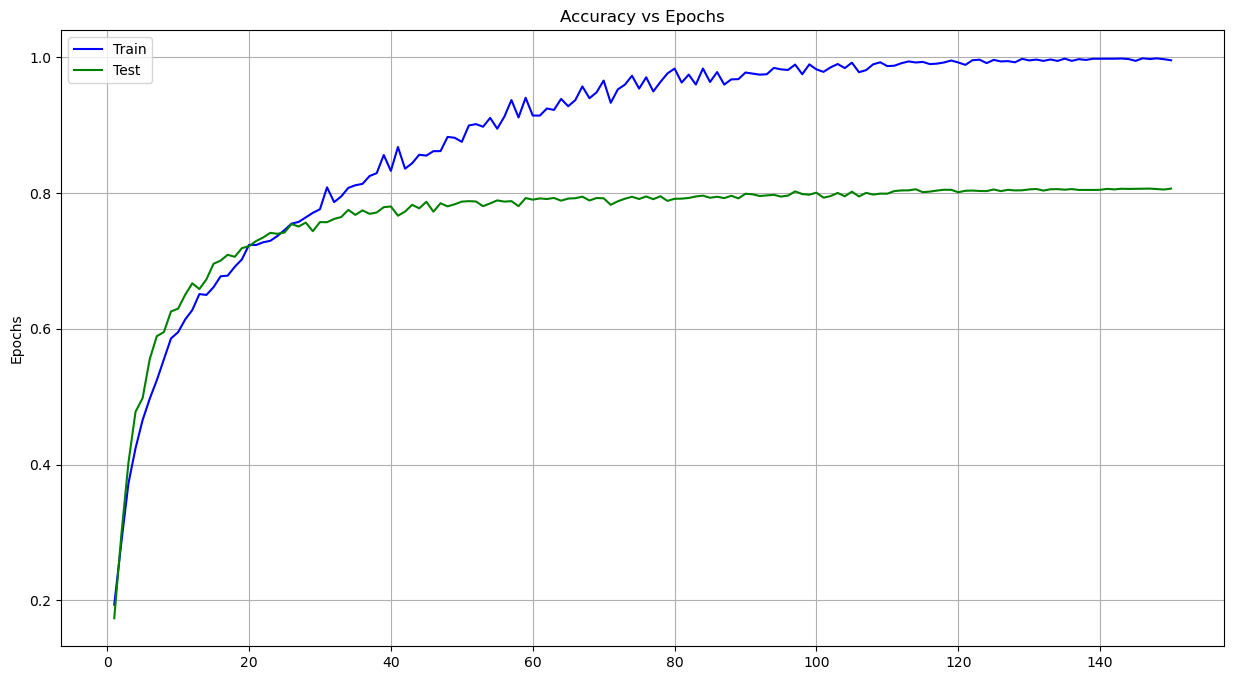

In [18]:
plt.figure(figsize=(15, 8))
plt.plot(epochs, train_accu,c='blue', linestyle = '-', label = 'Train')
plt.plot(epochs, test_accu ,c='green', linestyle = '-', label = 'Test')
plt.ylabel("Accuracy")
plt.ylabel('Epochs')
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

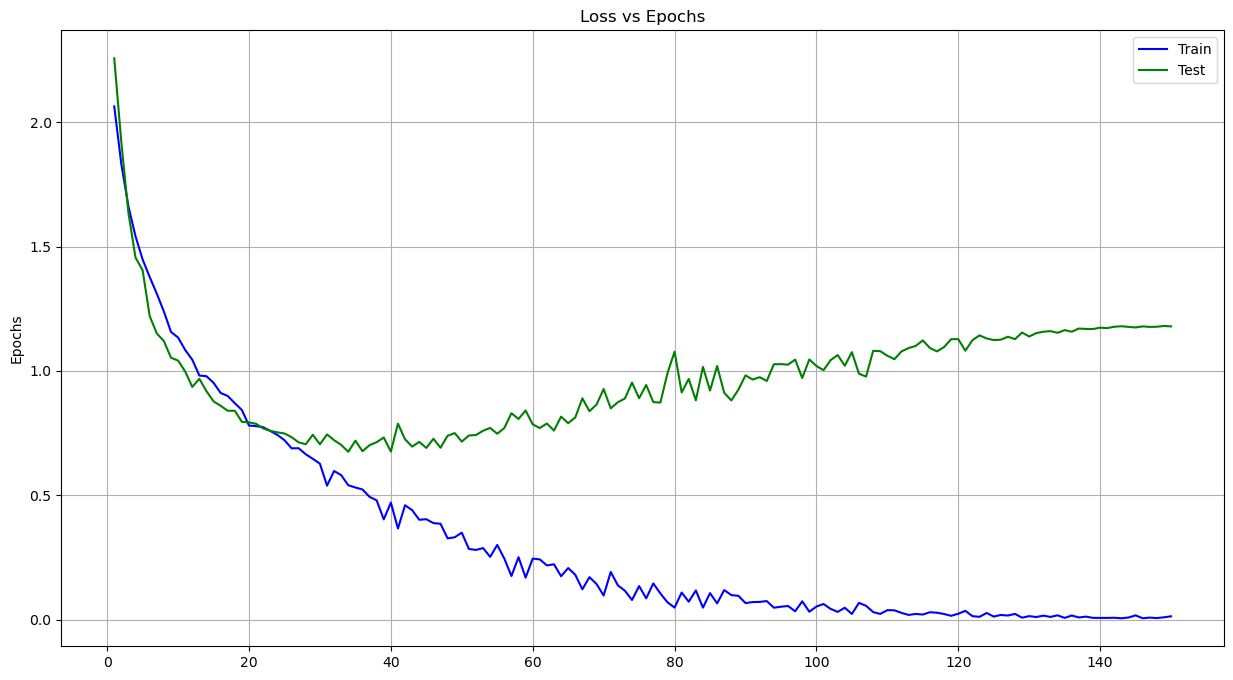

In [19]:
plt.figure(figsize=(15, 8))
plt.plot(epochs, train_loss,c='blue', linestyle = '-', label = 'Train')
plt.plot(epochs, test_loss ,c='green', linestyle = '-', label = 'Test')
plt.ylabel("Loss")
plt.ylabel('Epochs')
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()